In [123]:
M = 0

In [124]:
import re

import numpy as np
import pandas as pd

In [125]:
from tqdm.autonotebook import tqdm

## Importing Datasets

In [126]:
string_df = pd.read_csv("../../data/interim/string_df.csv", index_col=0)

balanced_pairs_df = pd.read_csv("../../data/train_test/test_pairs.csv", index_col=0)

balanced_pairs_df.drop_duplicates(inplace=True)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [127]:
string_df

,concatenated
label,
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
...,...
iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
iPhoneXSMax_M,0001101000101101010000000001101111111111000000...
iPhoneXSMax_M,0001101000101101000000000001101111111111000000...


In [128]:
balanced_pairs_df

,Item 1,Item 2,Equality,device1,device2
0,60,72,1,XiaomiRedmiNote7_S,XiaomiRedmiNote7_S
1,84,97,1,XiaomiRedmi5_J,XiaomiRedmi5_J
2,16,22,1,iPhoneXR_L,iPhoneXR_L
3,87,97,1,XiaomiRedmi5_J,XiaomiRedmi5_J
4,46,47,1,HuaweiHonor9_R,HuaweiHonor9_R
...,...,...,...,...,...
1995,25,40,-1,iPhoneXR_L,HuaweiHonor9_R
1996,49,107,-1,SamsungS7_I,XiaomiRedmiNote9S_T
1997,37,185,-1,HuaweiHonor9_R,GooglePixel3A_V
1998,156,186,-1,iPhone11_M,GooglePixel3A_V


## Importing Best Configurations

In [129]:
import re
import pandas as pd


def parse_log_file(filename):
    data = []

    with open(filename, "r") as file:
        lines = file.readlines()

        current_filter = None
        current_threshold = None
        current_min_error = None
        current_confidence = None

        for line in lines:
            if "Best Filter" in line:
                # Extract Best Filter using regex
                filter_match = re.search(r"Best Filter: (.+)", line)
                if filter_match:
                    current_filter = filter_match.group(1).strip()

            elif "Best Threshold" in line:
                # Extract Best Threshold using regex
                threshold_match = re.search(r"Best Threshold: (.+)", line)
                if threshold_match:
                    current_threshold = int(threshold_match.group(1).strip())

            elif "Min error" in line:
                # Extract Min Error using regex
                min_error_match = re.search(r"Min error: (.+)", line)
                if min_error_match:
                    current_min_error = float(min_error_match.group(1).strip())

            elif "Confidence" in line:
                # Extract Confidence using regex
                confidence_match = re.search(r"Confidence: (.+)", line)
                if confidence_match:
                    current_confidence = float(confidence_match.group(1).strip())

                    # Once we have all values, create a tuple and add it to the data list
                    data.append(
                        (
                            current_filter,
                            current_threshold,
                            current_min_error,
                            current_confidence,
                        )
                    )

                    # Reset current values for the next entry
                    current_filter = None
                    current_threshold = None
                    current_min_error = None
                    current_confidence = None

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(
        data, columns=["Best Filter", "Best Threshold", "Min Error", "Confidence"]
    )

    return df

In [130]:
# Usage example:
filename = "../../reports/best_config"
best_configs_df = parse_log_file(filename)

In [131]:
best_configs_df

,Best Filter,Best Threshold,Min Error,Confidence
0,0[304] 🀆🀆🀆🀆🀆🀆🀆🀆🀫🀫🀫🀫🀫🀫🀫🀫 0[1464],1,0.453672,0.185844
1,0[1752] 🀆🀆🀆🀆🀫🀫🀫🀫 0[24],1,0.459875,0.160845
2,0[328] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1448],1,0.460774,0.157226
3,0[304] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[1464],2,0.461820,0.153019
4,0[1664] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[104],1,0.459515,0.162296
5,0[312] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1464],1,0.464184,0.143508
6,0[1760] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[8],2,0.463862,0.144805
7,0[240] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[1528],1,0.471137,0.115582
8,0[1752] 🀫🀫🀫🀫🀫🀫🀫🀫 0[24],1,0.470016,0.120079
9,0[1768] 🀆🀆🀆🀆🀫🀫🀫🀫 0[8],1,0.471781,0.112996


In [132]:
if M != 0:
    best_configs_df = best_configs_df.head(M)

if M == 0:
    M = len(best_configs_df)

In [133]:
compression_rate = len(string_df["concatenated"].iloc[0]) / best_configs_df.shape[0]

print("Compression Rate:", compression_rate)

Compression Rate: 63.714285714285715


## Generate Matrix

In [134]:
def convertColumntoArray(df: pd.DataFrame, column_name: str) -> np.array:
    return np.array([list(bstr) for bstr in df[column_name]])

In [135]:
def generateStringPairDf(pairs_df: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    # Convert the Probes column to a numpy array
    dataset_array = convertColumntoArray(dataset, "concatenated")

    return_df = pd.DataFrame()

    # Import the Probes into the pairs_df dataframe
    return_df["Item 1"] = pairs_df["Item 1"].apply(lambda index: dataset_array[index])
    return_df["Item 2"] = pairs_df["Item 2"].apply(lambda index: dataset_array[index])
    return_df["Equality"] = pairs_df["Equality"]

    return return_df

In [136]:
matrix_pairs_df = generateStringPairDf(balanced_pairs_df, string_df)
matrix_pairs_df.reset_index(inplace=True, drop=True)

## Filters Parser

In [137]:
def filter_parser(input_string: str) -> list:
    # Split the string into its parts
    parts = input_string.split()

    # Initialize the final array
    result = []

    # Process each part
    for part in parts:
        if part.startswith("0["):
            # Extract the number inside the brackets
            count = int(part[2:-1])
            # Append the corresponding number of zeros to the result
            result.extend([0] * count)
        else:
            # Translate the tiles to their respective values
            for char in part:
                if char == "🀆":
                    result.append(-1)
                elif char == "🀫":
                    result.append(1)

    return result

In [138]:
# import time

# time.sleep(100)

## Apply Filters

In [139]:
def apply_filter(item, filter):
    # item = np.array(list(item)).astype(int)
    item = item.astype(int)
    filter = filter_parser(filter)
    return np.sum(np.multiply(item, filter))

In [140]:
def apply_filter_threshold(item, filter, threshold) -> int:
    if apply_filter(item, filter) > threshold:
        return 1
    else:
        return -1

In [141]:
def apply_filter_threshold_pair(item_1, item_2, filter, threshold) -> int:
    if apply_filter_threshold(item_1, filter, threshold) == apply_filter_threshold(
        item_2, filter, threshold
    ):
        return 1
    else:
        return -1

## Calculate Fingerprint

In [142]:
def hamming_distance(array1, array2, confidence):
    # Check if arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Initialize distance counter
    distance = 0

    # Iterate through arrays and count differences
    for i in range(len(array1)):
        if array1[i] != array2[i]:
            distance += confidence[i]

    distance = (distance / sum(confidence)) * len(confidence)

    return distance

In [143]:
def calculate_fingerprint(item_1, item_2, best_filters, best_thresholds, confidence):
    fingerprint_1 = []
    fingerprint_2 = []

    for best_filter, best_threshold in zip(best_filters, best_thresholds):
        filtered_1 = np.sum(np.multiply(item_1.astype(int), filter_parser(best_filter)))
        filtered_2 = np.sum(np.multiply(item_2.astype(int), filter_parser(best_filter)))

        if filtered_1 > best_threshold:
            filtered_1 = 1
        else:
            filtered_1 = -1

        if filtered_2 > best_threshold:
            filtered_2 = 1
        else:
            filtered_2 = -1

        fingerprint_1.append(filtered_1)
        fingerprint_2.append(filtered_2)

        distance = hamming_distance(fingerprint_1, fingerprint_2, confidence)

    return distance

In [144]:
for i, row in tqdm(matrix_pairs_df.iterrows(), total=matrix_pairs_df.shape[0]):
    # Extracting best filters and thresholds from the main DataFrame (assuming same filters and thresholds for simplicity)
    best_filters = best_configs_df["Best Filter"].tolist()
    best_thresholds = best_configs_df["Best Threshold"].tolist()
    confidence = best_configs_df["Confidence"].tolist()

    # Calculate the fingerprint using the relevant best filters and thresholds
    fingerprint = calculate_fingerprint(
        row["Item 1"], row["Item 2"], best_filters, best_thresholds, confidence
    )

    # Store the result in the 'distance' column (or any other processing you need)
    matrix_pairs_df.at[i, "h_distance"] = fingerprint

  0%|          | 0/2000 [00:00<?, ?it/s]

## H Distance Visualization

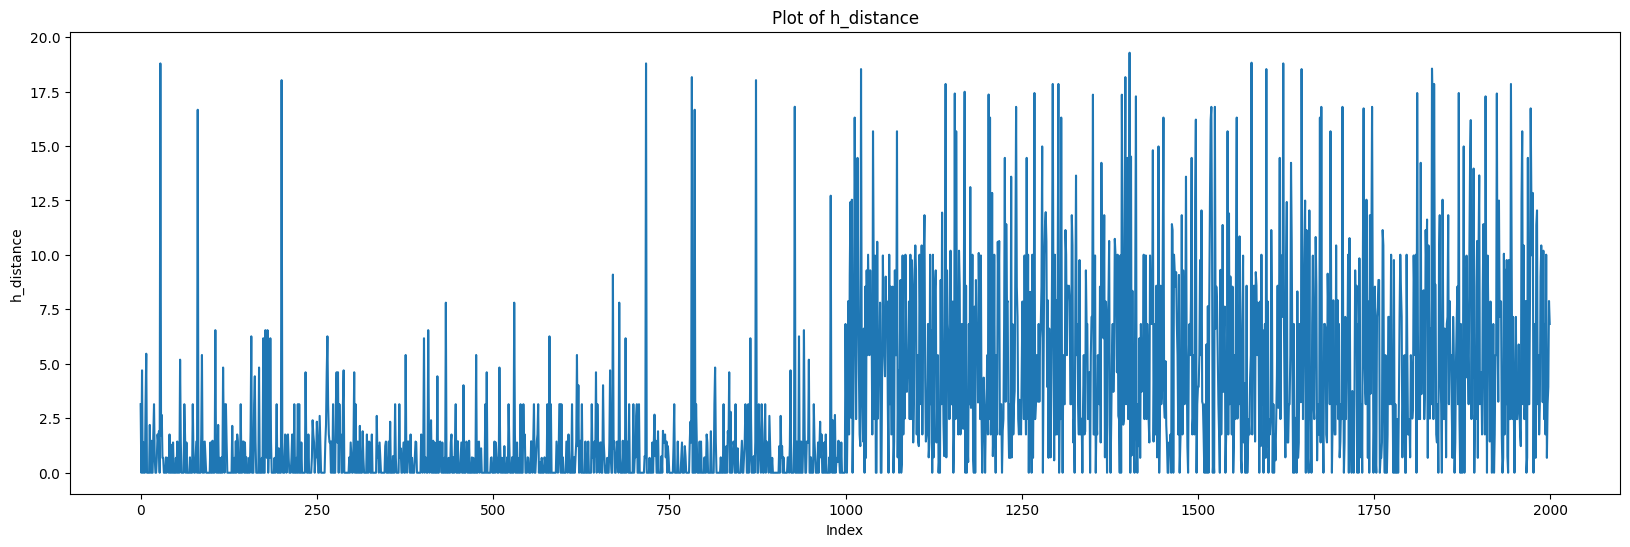

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))


# Assuming "matrix_pairs_df" is the DataFrame containing the "h_distance" column
plt.plot(matrix_pairs_df["h_distance"])
plt.xlabel("Index")
plt.ylabel("h_distance")
plt.title("Plot of h_distance")
plt.show()

## ROC

In [146]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

fprs = []
tprs = []
thresholds = []

taus = np.arange(1, len(best_configs_df) + 1, 0.01)

for tau in taus:
    predicted_labels = np.where(matrix_pairs_df["h_distance"] < tau, 1, -1)
    fpr, tpr, threshold = roc_curve(matrix_pairs_df["Equality"], predicted_labels)
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

# Flatten the lists and sort by FPR
fpr_all = np.concatenate(fprs)
tpr_all = np.concatenate(tprs)
sorted_indices = np.argsort(fpr_all)
fpr_sorted = fpr_all[sorted_indices]
tpr_sorted = tpr_all[sorted_indices]

# Interpolate TPR values
fpr_unique = np.unique(fpr_sorted)
tpr_interpolated = np.interp(fpr_unique, fpr_sorted, tpr_sorted)

In [147]:
# Create a DataFrame
roc_data = pd.DataFrame(
    {
        "fpr": fpr_sorted,
        "tpr": tpr_sorted,
    }
)

# Save to CSV
roc_data.to_csv(f"../../reports/CSV/ROC/roc_curve_data_{M}.csv", index=False)

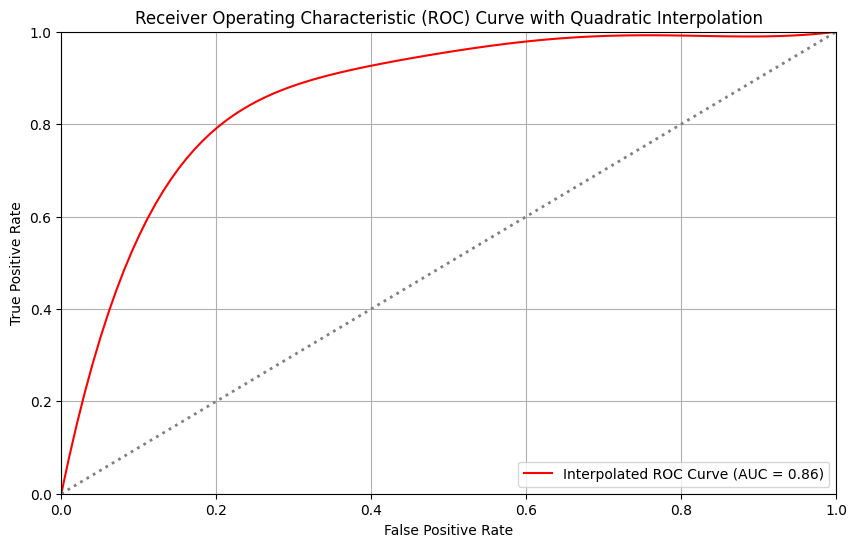

In [148]:
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming fpr_sorted and tpr_sorted are already defined and computed

# Interpolate using quadratic polynomial
poly_degree = 6
coefficients = np.polyfit(fpr_sorted, tpr_sorted, poly_degree)
poly = np.poly1d(coefficients)
fpr_interpolated = np.linspace(0, 1, 100)  # Adjust number of points as needed
tpr_interpolated = poly(fpr_interpolated)

# Ensure the ROC curve starts from (0, 0)
if fpr_interpolated[0] != 0 or tpr_interpolated[0] != 0:
    fpr_interpolated = np.insert(fpr_interpolated, 0, 0)
    tpr_interpolated = np.insert(tpr_interpolated, 0, 0)

# Calculate AUC for interpolated curve
roc_auc = auc(fpr_interpolated, tpr_interpolated)

# Plot interpolated ROC curve with filled area
plt.figure(figsize=(10, 6))

# Plot interpolated ROC curve
sns.lineplot(
    x=fpr_interpolated,
    y=tpr_interpolated,
    label=f"Interpolated ROC Curve (AUC = {roc_auc:.2f})",
    color="red",
)

# Fill area between the curve and the diagonal line
# plt.fill_between(
#     fpr_interpolated,
#     tpr_interpolated,
#     color="blue",
#     alpha=0.2,
#     label="Interpolated TPR Range",
# )

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="dotted")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve with Quadratic Interpolation")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [149]:
print("Compression Rate:", compression_rate)

Compression Rate: 63.714285714285715


## Reconstructed Plot

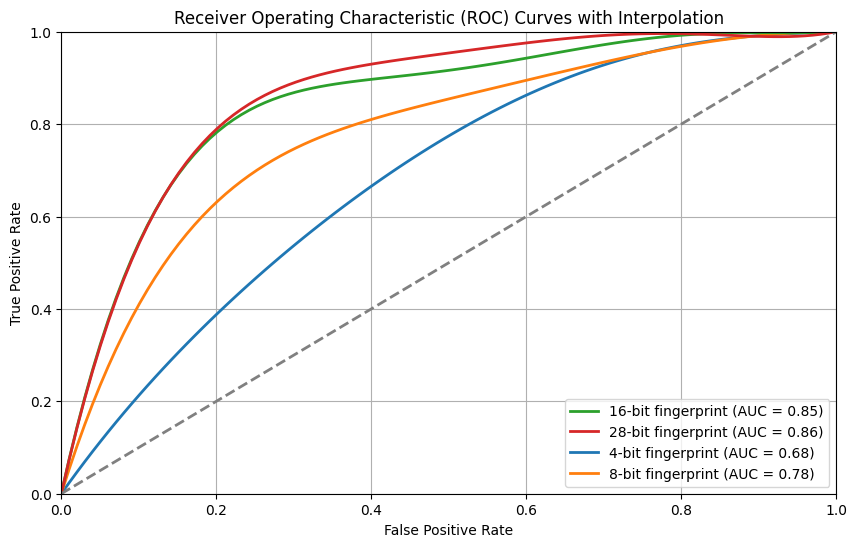

In [151]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns


def plot_roc_curves_from_folder(folder_path):
    # Get all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

    # Initialize a figure
    plt.figure(figsize=(10, 6))

    # List to store line objects and their corresponding labels
    lines = []
    labels = []

    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read CSV file into a DataFrame
        file_path = os.path.join(folder_path, csv_file)
        roc_data = pd.read_csv(file_path)

        # Extract data from DataFrame
        fpr = roc_data["fpr"]
        tpr = roc_data["tpr"]

        # Extract number of bits from filename using regex
        match = re.search(r"_(\d+)", csv_file)
        if match:
            bits = match.group(1)
        else:
            bits = "Unknown"

        # Interpolate using quadratic polynomial
        poly_degree = 5  # Quadratic interpolation
        coefficients = np.polyfit(fpr, tpr, poly_degree)
        poly = np.poly1d(coefficients)
        fpr_interpolated = np.linspace(0, 1, 100)  # Adjust number of points as needed
        tpr_interpolated = poly(fpr_interpolated)

        # Ensure the ROC curve starts from (0, 0)
        if fpr_interpolated[0] != 0 or tpr_interpolated[0] != 0:
            fpr_interpolated = np.insert(fpr_interpolated, 0, 0)
            tpr_interpolated = np.insert(tpr_interpolated, 0, 0)

        # Calculate AUC for interpolated curve
        roc_auc = auc(fpr_interpolated, tpr_interpolated)

        # Plot ROC curve with interpolated values
        (line,) = plt.plot(
            fpr_interpolated,
            tpr_interpolated,
            lw=2,
            label=f"{bits}-bit fingerprint (AUC = {roc_auc:.2f})",
        )

        # Collect line objects and labels for sorting
        lines.append(line)
        labels.append(f"{bits}-bit fingerprint (AUC = {roc_auc:.2f})")

    # Sort labels and lines by label
    lines_labels = sorted(zip(lines, labels), key=lambda x: x[1])
    lines, labels = zip(*lines_labels)

    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves with Interpolation")
    plt.legend(lines, labels, loc="lower right")
    plt.grid(True)
    plt.show()


# Example usage:
folder_path = "../../reports/CSV/ROC/"
plot_roc_curves_from_folder(folder_path)